# Supervisely Python SDK Tutorial #1

Here we cover the basics of working with annotated images in Supervisely format using our Python SDK: exploring and modifying data projects, and analysing and visualizing the image labeling data, both spatial and categorical. The Python SDK will be most useful when developing custom Supervisely plugins, like custom format imports or new neural network architectures, or when processing datasets in Supervisely format.

We have aimed to design the SDK to make the most frequent data analysis and transformation tasks as easy as possible. Here is a teaser of what you can do with a few lines of code:

In [1]:
import supervisely_lib as sly  # Supervisely Python SDK

# Open existing project on disk.
project = sly.Project('./tutorial_project', sly.OpenMode.READ)
# Locate and load image labeling data.
item_paths = project.datasets.get('dataset_01').get_item_paths('bicycle-car')
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
# Go over the labeled objects and print out basic properties.
for label in ann.labels:
    print('Found label object: ' + label.obj_class.name)
    print('   geometry type: ' + label.geometry.geometry_name())
    print('   object area: ' + str(label.geometry.area))

Found label object: bike
   geometry type: rectangle
   object area: 88109.0
Found label object: car
   geometry type: polygon
   object area: 323207.0


Another example is rendering the labeled objects as bitmaps:

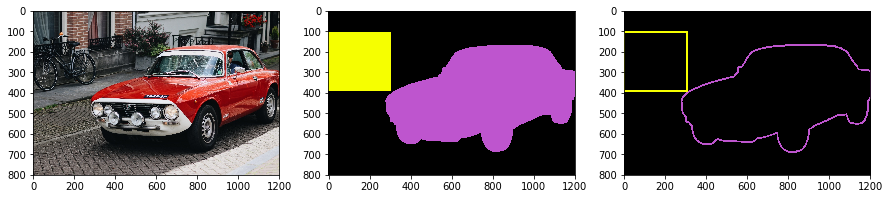

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Read the underlying raw image for display.
img = sly.image.read(item_paths.img_path)
# Render the labeled objects.
ann_render = np.zeros(ann.img_size + (3,), dtype=np.uint8)
ann.draw(ann_render)
# Separately, render the labeled objects contours.
ann_contours = np.zeros(ann.img_size + (3,), dtype=np.uint8)
ann.draw_contour(ann_contours, thickness=7)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(ann_render)
plt.subplot(1, 3, 3)
plt.imshow(ann_contours)

Now that you have had a glimpse of the SDK usage, let us start properly with the basics.

# Projects and datasets basics

All data in Supervisely is organized into **projects**. Every project contains two kinds of data:
1. labeled images, grouped into **datasets**.
2. labeling **meta-information** (available labeling classes and tags).

This tutorial walks you through using **Supervisely Python SDK** [TODO link?] to work with projects *offline* (downloaded to local disk). Offline mode is mainly useful when developing new plugins or running Python code directly on the Supervisely instance.

For some lightweight tasks (like just reading the set of labeling classes used in the project), downloading the whole project is too wasteful. Instead, it may be much more efficient to use our *online Python API* [TODO link?] to query and update projects directly on-instance. See this tutorial [TODO LINK] to learn more about the online API.

## Hello Project - explore the data

All the project data manipulation with Supervisely SDK starts with a `Project` class. It is a lightweight wrapper to store the metadata and information on avaliable datasets and images. Let us open an existing toy project:

In [3]:
import supervisely_lib as sly  # Supervisely Python SDK
import json                    # Add Python JSON module for pretty-printing.

# Load the project meta-data.
# This does NOT load the images or their labeling data in memory.
project = sly.Project('./tutorial_project', sly.OpenMode.READ)

With an opened project, we can get some basic information: its name, location on disk, member datasets, the total number of images. We can also iterate over the datasets, and go over the images in each dataset.

In [4]:
# Print basic project metadata.
print("Project name: ", project.name)
print("Project directory: ", project.directory)
print("Total images: ", project.total_items)
print("Dataset names: ", project.datasets.keys())
print("\n")

# What datasets and images are there and where are they on disk?
for dataset in project:
    print("Dataset: ", dataset.name)
    
    # A dataset item is a pair of an image and its annotation.
    # The annotation contains all the labeling information about
    # the image - segmentation masks, objects bounding boxes etc.
    # We will look at annotations in detail shortly.
    for item_name in dataset:
        print(item_name)
        img_path = dataset.get_img_path(item_name)
        print("  image: ", img_path)
    print()

Project name:  tutorial_project
Project directory:  ./tutorial_project
Total images:  5
Dataset names:  ['dataset_02', 'dataset_01']


Dataset:  dataset_02
bmw
  image:  ./tutorial_project/dataset_02/img/bmw.jpeg
snow-city
  image:  ./tutorial_project/dataset_02/img/snow-city.jpeg

Dataset:  dataset_01
bicycle-car
  image:  ./tutorial_project/dataset_01/img/bicycle-car.jpeg
bike-man-dog
  image:  ./tutorial_project/dataset_01/img/bike-man-dog.jpeg
car-people-indoors
  image:  ./tutorial_project/dataset_01/img/car-people-indoors.jpeg



### Image annotations and meta-information
Raw images by themselves are not very interesting. What really makes the data valuable is the labeling information. We call all the information about a single image its **annotation**. Annotations are stored as JSON files (one per image), and are available via `Annotation` objects in the SDK.

Supervisely supports two kinds of labeling information:
1. **Geometric** labels. Available via `Label` class. Segmentation masks, polygons, object bounding boxes, points on images - anything that has spatial properties is represented as a `Label`.
2. **Tags**, which have no spatial data. Available via `Tag` class. Tags can be assigned to the whole image or to an individual label.

Finally, it is important that annotations for different images within the same projects use a *consistent* set of label classes and tags. Suppose half of the images have cars labeled as bounding boxes, and the other half as carefully segmented per-pixel masks. Such a discrepancy is often a sign of problematic data quality. To maintain and enforce consistency between annotations, each Supervisely project explicitly stores **meta information**, available via `ProjectMeta` class in the SDK. `ProjectMeta` defines the labels and tags available for the given project:
1. For geometric labels, `ObjClass` objects store semantic class name, geometry type (e.g. bitmap, polygon, rectangle) and color. Each `Label` refers to its `ObjClass` object for the semantic information.
2. For tags, `TagMeta` objects defne the available tag names, and for each tag the range of possible values (so that you can define `traffic_light_color:red` to be a valid combination, but `traffic_light_color:chair` to be invalid).

The metadata available via `Project` directly matches what you see for that project in the Supervisely UI.

Python SDK `ProjectMeta`:

In [5]:
print(project.meta)

ProjectMeta:
Object Classes
+--------+-----------+----------------+
|  Name  |   Shape   |     Color      |
+--------+-----------+----------------+
|  bike  | Rectangle | [246, 255, 0]  |
|  car   |  Polygon  | [190, 85, 206] |
|  dog   |  Polygon  |  [253, 0, 0]   |
| person |   Bitmap  |  [0, 255, 18]  |
+--------+-----------+----------------+
Image Tags
+-------------+--------------+-----------------------+
|     Name    |  Value type  |    Possible values    |
+-------------+--------------+-----------------------+
|   situated  | oneof_string | ['inside', 'outside'] |
|     like    |     none     |          None         |
| cars_number |  any_number  |          None         |
+-------------+--------------+-----------------------+
Object Tags
+---------------+--------------+-----------------------+
|      Name     |  Value type  |    Possible values    |
+---------------+--------------+-----------------------+
|   car_color   |  any_string  |          None         |
| person_gender 

Compare with Supervisely UI label meta:
![object classes](https://i.imgur.com/c6XySD1.png)
UI tags meta:
![tag metas](https://i.imgur.com/o7NXrvH.png)

Load an image annotation and read off basic information:

In [6]:
# Grab the file paths for both raw image and annotation in one call.
item_paths = project.datasets.get('dataset_01').get_item_paths('bicycle-car')

# Load and deserialize annotation from JSON format.
# Annotation data is cross-checked again project meta, and references to
# the right LabelMeta and TagMeta objects are set up.
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)

print('Loaded annotation has {} labels and {} image tags.'.format(len(ann.labels), len(ann.img_tags)))
print('Label class names: ' + (', '.join(label.obj_class.name for label in ann.labels)))
print('Image tags: ' + (', '.join(tag.get_compact_str() for tag in ann.img_tags)))

Loaded annotation has 2 labels and 0 image tags.
Label class names: bike, car
Image tags: 


We can easily render all the labels in the annotation to a bitmap for visualization:

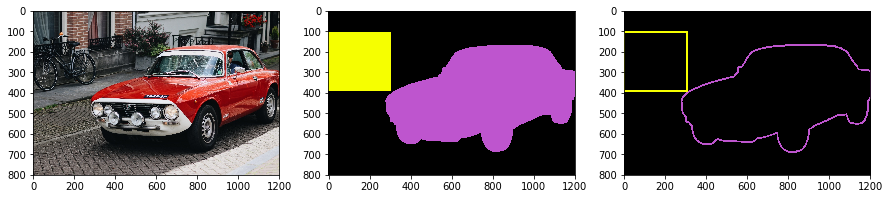

In [7]:
# Basic imaging functionality and Jupyter image display helpers.
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# A helper to display several images in a row.
# Can be safely skipped - not essentiall for understanding the rest of the code.
def display_images(images, figsize=None):
    plt.figure(figsize=(figsize if (figsize is not None) else (15, 15)))
    for i, img in enumerate(images, start=1):
        plt.subplot(1, len(images), i)
        plt.imshow(img)

# Set up a 3-channel black canvas to render annotation labels on.
# Make the canvas size match the original image size.
ann_render = np.zeros(ann.img_size + (3,), dtype=np.uint8)

# Render all the labels using colors from the meta information.
ann.draw(ann_render)

# Set up canvas to draw label contours.
ann_contours = np.zeros(ann.img_size + (3,), dtype=np.uint8)

# Draw thick contours for the labels on a separate canvas.
ann.draw_contour(ann_contours, thickness=7)

# Load the original image too.
img = sly.image.read(item_paths.img_path)

# Display everything.
display_images([img, ann_render, ann_contours])

Next we turn to working with labeling data on a finer grained level, dealing with individual semantic objects within the annotation.

### Geometric labels
A `Label` is the primary type that we work with when processing annotations. A label is a combination of three main compontnets:
1. `ObjClass` instance from the project meta indicating the semantic class of the label.
2. Geometrical data, represented as a specific object (`Bitmap`, `Rectangle`, `Polygon`) that inherits from a common `Geometry` interface.
3. Other meta-information (tags, description).

Let us first explore existing labels:

In [8]:
for label in ann.labels:
    print('Label class: {}; type: {}; label area: {}'.format(
        label.obj_class.name,
        label.geometry.geometry_name(),
        label.geometry.area))
    
    for tag in label.tags:
        print('Tag: ' + tag.get_compact_str())
    print()

Label class: bike; type: rectangle; label area: 88109.0

Label class: car; type: polygon; label area: 323207.0
Tag: vehicle_age:vintage
Tag: car_color:red



One can easily filter by the all the available properties. For example, let us find all the images in the dataset that contain cars where the cars are large enough:

In [9]:
filtered_items = []
for dataset in project:
    for item_name in dataset:
        ann_path = dataset.get_ann_path(item_name)
        ann = sly.Annotation.load_json_file(ann_path, project.meta)
        if any(label.obj_class.name == 'car' and label.geometry.area > 200000
               for label in ann.labels):
            filtered_items.append((dataset.name, item_name))
print(sorted(filtered_items))

[('dataset_01', 'bicycle-car'), ('dataset_01', 'car-people-indoors')]


#### Label rendering and rasterization

A typical step in training segmentation neural networks is marking every pixel of a training image with its semantic class. With Supervisely SDK, this can be done in a uniform way, regardless of whether the underlying label is a rectabgle, polygon or a binary mask:

Label type: rectangle
Label type: polygon


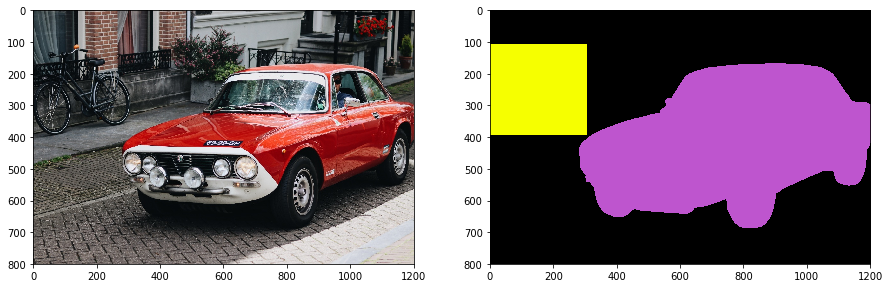

In [10]:
# Load the data and set up black canvas.
item_paths = project.datasets.get('dataset_01').get_item_paths('bicycle-car')
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
img = sly.image.read(item_paths.img_path)
rendered_labels = np.zeros(ann.img_size + (3,), dtype=np.uint8)

for label in ann.labels:
    print('Label type: ' + label.geometry.geometry_name())
    # Same call for any geometry type.
    label.draw(rendered_labels)

display_images([img, rendered_labels])

When training a detection neural net, we usually want to convert all the labels to their respective **bounding boxes**. This is also done in a uniform way for all the geometric label types:

Label type: rectangle
Label bounding box: [107, 0, 393, 306]
Label type: polygon
Label bounding box: [168, 279, 687, 1199]


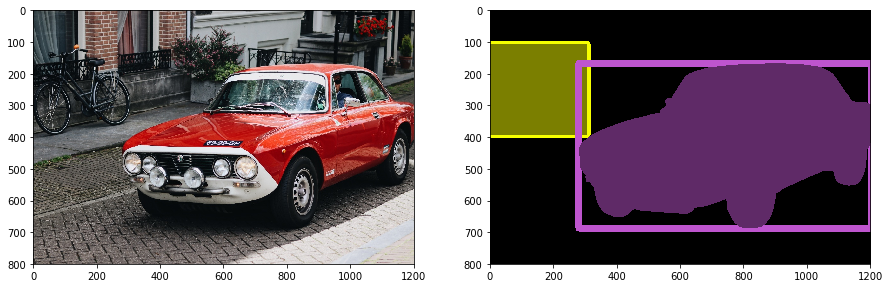

In [11]:
rendered_bboxes = np.zeros(ann.img_size + (3,), dtype=np.uint8)

for label in ann.labels:
    print('Label type: ' + label.geometry.geometry_name())
    
    # Same call for any label type.
    bbox = label.geometry.to_bbox()
    print('Label bounding box: [{}, {}, {}, {}]'.format(
        bbox.top, bbox.left, bbox.bottom, bbox.right))
    
    # Draw the bounding boxes.
    bbox.draw_contour(rendered_bboxes, color = label.obj_class.color, thickness=20)
    
    # Draw the labels themselves too to make sure the bounding boxes are correct.
    label.geometry.draw(rendered_bboxes, color=[int(x/2) for x in label.obj_class.color])

display_images([img, rendered_bboxes])

### Image-level tags
In addition to individual labels we can also tag whole images in the same way:

In [12]:
dataset = project.datasets.get('dataset_02')
for item_name in dataset:
    print('Item: ' + item_name)
    
    ann_path = dataset.get_ann_path(item_name)
    ann = sly.Annotation.load_json_file(ann_path, project.meta)
    for tag in ann.img_tags:
        print('   Tag: ' + tag.get_compact_str())

Item: bmw
Item: snow-city


## Create and populate a new project
Here we will see how to create a new dataset that is a modification of an existing one. We will add flipped versions of all the original annotated images and add a background class to every image.

### Create a new empty project
To create a new project, simply pass to the constructor the target location directory on the file system. The directory should *not* already exist - to avoid accidentally corrupting existing files, the constructor fails if the directory is already there.

The project constructor will create the target directory and write out serialized (empty so far) metadata right away.

In [13]:
import os

# A helper to pretty-print project on-disk files.
# Can be safely skipped - not essentiall for understanding the rest of the code.
def print_project_files(project_dir):
    files_with_sizes = {
        filename: sly.fs.get_file_size(os.path.join(project_dir, filename))
        for filename in sly.fs.list_dir_recursively(project_dir)}
    files_text = '\n'.join(
        '\t{}: {} bytes'.format(filename, files_with_sizes[filename])
        for filename in sorted(files_with_sizes.keys()))
    print('Project contents:\n{}\n'.format(str(files_text)))    

# Directory path to create the new project in
MODIFIED_PROJECT_DIR = './modified_project'

# Remove the target directory in case it is left over from previous runs.
sly.io.fs.remove_dir(MODIFIED_PROJECT_DIR)

print('Creating project...')
dest_project = sly.Project(MODIFIED_PROJECT_DIR, sly.OpenMode.CREATE)

# Creating a project immediately writes out a serialized meta file to disk.
print_project_files(MODIFIED_PROJECT_DIR)

Creating project...
Project contents:
	meta.json: 54 bytes



### Set up new project metadata

Before we can start assigning labels and tags to image annotations, we need to set up the available semantic object classes and tags in the project meta. We can either populate a new empty meta from scratch, or modify existing meta as needed.

For simplicity, we take the meta from our existing demo project and add a single new object class to it.

A key point to note here is that when we make a modification **the original meta object is not changed**. Instead, **a modified copy is created and returned**. This is a pattern that will repeat with other types - `Annotation`, `Label`, various kinds of `Geometry` all behave this way.

In [14]:
# Start off with the meta of the original existing project.
updated_dest_meta = project.meta

# Make a new object class to be added to the meta.
bg_obj_class = sly.ObjClass(
    name='background',
    geometry_type=sly.Rectangle,
    color=[100, 100, 100])

# Original meta object is immutable - modification operations create new objects.
# This is a common pattern with most other classes in the SDK
# (semantic labels, geometry data, tags data).
updated_dest_meta = project.meta.add_obj_class(bg_obj_class)

# Make sure the original meta is unmodified,
print('Original meta has {} label classes'.format(len(project.meta.obj_classes)))
print('Class "{}" is in original meta: {}'.format(
    bg_obj_class.name, bg_obj_class in project.meta.obj_classes))

# The updated meta must contain the newly added object class.
print('Updated meta has {} label classes'.format(len(updated_dest_meta.obj_classes)))
print('Class "{}" is in updated meta: {}\n'.format(
    bg_obj_class.name, bg_obj_class in updated_dest_meta.obj_classes))

# Set the new meta in the destination project.
print('Updating project meta...')
dest_project.set_meta(updated_dest_meta)

# Updated meta is written to disk immediately. Note the larger file size
# compared to the freshly created state above.
print_project_files(MODIFIED_PROJECT_DIR)

Original meta has 4 label classes
Class "background" is in original meta: False
Updated meta has 5 label classes
Class "background" is in updated meta: True

Updating project meta...
Project contents:
	meta.json: 876 bytes



### Populate the new project with labeled images
Now we can move on to filling the new project with annotated images. Instead of filling in the annotations from scratch, we will take existing annotations from the demo project and modify those. We will
1. Add a full-image background object to every image.
2. Add a horizontally flipped version (with correspondingly flipped annotation), a popular and simple technique of training data augmentation.
Again, notice here that the annotation are **not modified in place**. Instead, a **new modified instance is created**.

In [15]:
# Iterate over existing datasets...
for dataset in project:
    
    # Create a corresponding dataset in the newly created project.
    dest_dataset = dest_project.create_dataset(dataset.name + '_dest')    
    
    # Iterate over labeled images.
    for item_name in dataset:
        
        # Load the image and annotation.
        item_paths = dataset.get_item_paths(item_name)
        img = sly.image.read(item_paths.img_path)
        ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
        
        # Prepare the new background label to fill up the whole image.
        # Use the background object class that we have created in section above.
        bg_label = sly.Label(
            geometry=sly.Rectangle.from_size(ann.img_size),
            obj_class=bg_obj_class)
        
        # Make a new annotation by replacing the old list of labels with the new one.
        #
        # Order matters - labels are rasterized in-order by default, so later labels
        # have higher priority. Put the new background label first so that all the other
        # objects are rasterized on top of it. In other words, make sure the background
        # is only visible where there is no other meaningful label.
        #
        # The clone() method accepts parts of the source annotation to override.
        # Here we are replacing the original labels from ann with a new list.
        ann_with_bg = ann.clone(labels = ([bg_label] + ann.labels))
        
        # Add the image and updated annotation to the new datset.
        # Note that here we need to supply an image extension to tell the system which format
        # to store the data in.
        dest_dataset.add_item_np(
            item_name, img,
            img_ext=sly.fs.get_file_ext(item_paths.img_path),
            ann=ann_with_bg)
        
        # Make a horizontally flipped version of this annotated image.
        # aug module contains the basic augmentation operations -
        # flipping, resizing, cropping.
        img_flipped, ann_flipped = sly.aug.fliplr(img=img, ann=ann_with_bg)
        
        # Add the flipped version also to the dataset.
        dest_dataset.add_item_np(
            item_name + '-flipped', img_flipped,
            img_ext=sly.fs.get_file_ext(item_paths.img_path),
            ann=ann_flipped)

# Hooray, we have populated a new project with augmented version of the original
# project. Neural net training should give slightly more robust results on our
# new project.
print_project_files(MODIFIED_PROJECT_DIR)

Project contents:
	dataset_01_dest/ann/bicycle-car-flipped.json: 2546 bytes
	dataset_01_dest/ann/bicycle-car.json: 2631 bytes
	dataset_01_dest/ann/bike-man-dog-flipped.json: 5510 bytes
	dataset_01_dest/ann/bike-man-dog.json: 5556 bytes
	dataset_01_dest/ann/car-people-indoors-flipped.json: 5933 bytes
	dataset_01_dest/ann/car-people-indoors.json: 5935 bytes
	dataset_01_dest/img/bicycle-car-flipped.jpeg: 472278 bytes
	dataset_01_dest/img/bicycle-car.jpeg: 472366 bytes
	dataset_01_dest/img/bike-man-dog-flipped.jpeg: 405110 bytes
	dataset_01_dest/img/bike-man-dog.jpeg: 405245 bytes
	dataset_01_dest/img/car-people-indoors-flipped.jpeg: 399240 bytes
	dataset_01_dest/img/car-people-indoors.jpeg: 399060 bytes
	dataset_02_dest/ann/bmw-flipped.json: 2651 bytes
	dataset_02_dest/ann/bmw.json: 2559 bytes
	dataset_02_dest/ann/snow-city-flipped.json: 3703 bytes
	dataset_02_dest/ann/snow-city.json: 3694 bytes
	dataset_02_dest/img/bmw-flipped.jpeg: 263536 bytes
	dataset_02_dest/img/bmw.jpeg: 263693 byte

Visualize both the flipped and non-flipped data for the same source image. Make sure the horizontal flip worked as intended and both annotations have full-image background class labels.

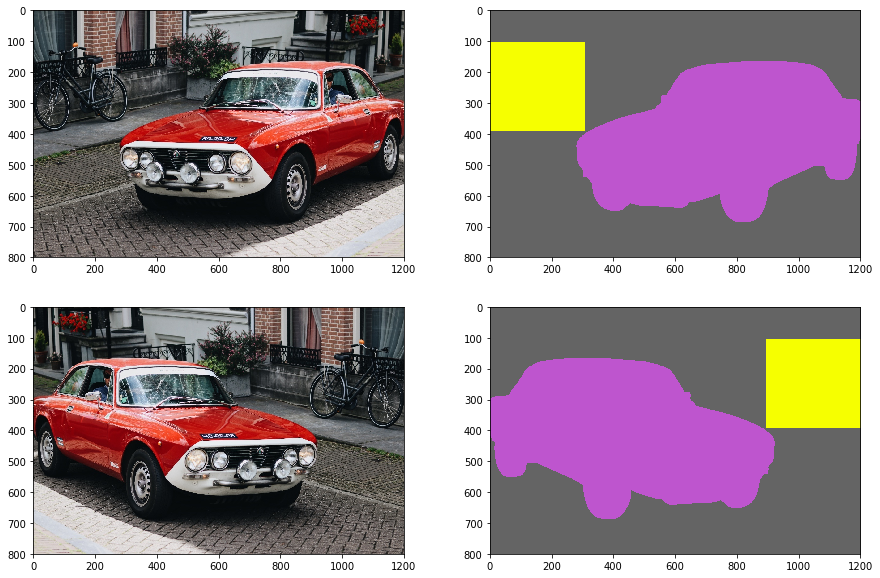

In [16]:
def load_img_render_ann(project, dataset_name, item_name):
    item_paths = project.datasets.get(dataset_name).get_item_paths(item_name)
    ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
    ann_render = np.zeros(ann.img_size + (3,), dtype=np.uint8)
    ann.draw(ann_render)
    img = sly.image.read(item_paths.img_path)
    return img, ann_render

img, ann_render = load_img_render_ann(
    dest_project, 'dataset_01_dest', 'bicycle-car')
img_flipped, ann_render_flipped = load_img_render_ann(
    dest_project, 'dataset_01_dest', 'bicycle-car-flipped')

# Display everything.
plt.figure(figsize=(15, 10))
# Top row - original orientation.
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(ann_render)
# Bottom row - flipped version.
plt.subplot(2,2,3)
plt.imshow(img_flipped)
plt.subplot(2,2,4)
plt.imshow(ann_render_flipped)

### Direct on-disk project copy
Often we need to make a minor modification to the labeling data of a project. Say, we only want to retain the labels that have type `Polygon` and a large enough area. We could use the same approach as above, creating an empty project and populating it with labeled images from the source project, and that would work fine. But notice that we would then read the source image JPEG files only to write them out to a new location. That is wasteful.

A good alternative when we do not need any modifications to the images is to first make a *copy* of the source project on-disk, and then modify the labels in place. This is also supported by our SDK:

In [17]:
# Directory name to copy the project to.
CLONED_PROJECT_NAME = 'cloned_project'

# Remove the target directory in case it is left over from previous runs.
sly.io.fs.remove_dir('./' + CLONED_PROJECT_NAME)

# Effective destination directory is a combination of dst_directory and dst_name.
project.copy_data(dst_directory='.', dst_name=CLONED_PROJECT_NAME)

# Open the newly cloned project and print basic metadata.
cloned_project = sly.Project('./' + CLONED_PROJECT_NAME, sly.OpenMode.READ)
print("Project name: ", cloned_project.name)
print("Project directory: ", cloned_project.directory)
print("Total images: ", cloned_project.total_items)
print("Dataset names: ", cloned_project.datasets.keys())

Project name:  cloned_project
Project directory:  ./cloned_project
Total images:  5
Dataset names:  ['dataset_02', 'dataset_01']


Now we can modify `cloned_project` annotations in-place without touching that images JPEG data at all.

In [18]:
for dataset in cloned_project:
    print("Dataset: ", dataset.name)
    
    for item_name in dataset:
        ann_path = dataset.get_ann_path(item_name)
        ann = sly.Annotation.load_json_file(ann_path, cloned_project.meta)
        
        # Apply the filtering to find the labels to be retained.
        # Only keep Polygon labels with large enough area.
        retained_labels = [
            label for label in ann.labels
            if isinstance(label.geometry, sly.Polygon) and label.geometry.area > 120000]
        
        # Make a copy of the original annotation, but only keep
        # retained_labels there.
        ann_filtered = ann.clone(labels=retained_labels)
        
        # Update the annotation on disk.
        dataset.set_ann(item_name, ann_filtered)
        
        # Print label counts before and after.
        print('  Item {}; labels originally: {}; after filtering: {}.'.format(
            item_name, len(ann.labels), len(ann_filtered.labels)))
    print()

Dataset:  dataset_02
  Item bmw; labels originally: 2; after filtering: 0.
  Item snow-city; labels originally: 3; after filtering: 1.

Dataset:  dataset_01
  Item bicycle-car; labels originally: 2; after filtering: 1.
  Item bike-man-dog; labels originally: 3; after filtering: 0.
  Item car-people-indoors; labels originally: 5; after filtering: 1.



## Modifying annotations and labels
Keeping in mind that `Annotation` objects are by themselves immutable, and making a change involves creating a new instance, there are three possible ways to modify an annotation:
1. Built-in methods for simple geometric modifications, e.g.
  1. `Annotation.crop_labels()` to crop all the labels to the same rectangle.
  2. `aug.fliplr()`, `aug.flipud()`, `aug.resize()`, `aug.rotate()` work on annotation-image pairs and transform both components to keep the geometric labels aligned with the underlying image.
2. Building up an updated list of labels separately and then using `Annotation.clone(labels=new_labels)` to get a copy with the existing labels replaced by the new list.
3. Supplying a *transform function* that takes a label and outputs a list of resulting labels to `Annotation.transform_labels()` to build the resulting labels list automatically.

### Built-in transformations
The easiest way of modifying annotations is to use built-in methods of the `Annotation` class and `aug` module of the SDK. Transformations that affect the geometry of the underlying image (rotations, scaling, resizing) are implemented in the `aug` module and take a pair of an image and an annotation as arguments, to make sure that both are transfomed consistently anf the transformed labels match the transformed image.

For an example, we will crop off the annotations along the boundary of the image and rotate the resulting by 90 degrees.

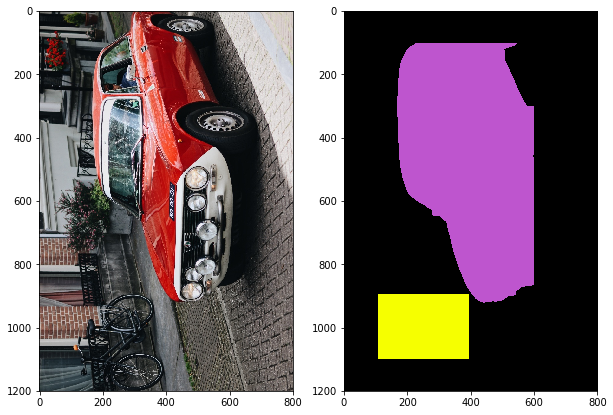

In [19]:
# Load the source image and annotation
item_paths = project.datasets.get('dataset_01').get_item_paths('bicycle-car')
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
img = sly.image.read(item_paths.img_path)

# Set up a cropping rectangle:
# 200 pixels away from bottom and 100 pixels away from other image boundaries.
crop_rect = sly.Rectangle(top=100, left=100,
                          bottom=(ann.img_size[0] - 201),
                          right=(ann.img_size[1] - 101))

# Crop all the labels to only preserve the parts falling inside the rectangle.
# Note that this does *not* affect the underlying image - the labels locations
# remain in the context of the original image size.
cropped_ann = ann.crop_labels(crop_rect)

# Rotate the cropped annotation along with the underlying image.
rotated_img, rotated_ann = sly.aug.rotate(
    img=img, ann=cropped_ann, degrees=90)

# Draw and display the results.
rotated_ann_render = np.zeros(rotated_ann.img_size + (3,), dtype=np.uint8)
rotated_ann.draw(rotated_ann_render)
display_images([rotated_img, rotated_ann_render], figsize=(10, 15))

### Construct new labels externally
It is infeasible to cover all the possible use cases with one-line built-in helpers, so we need a general extensible way of updating the label. The simplest way is to just construct a full set of new labels externally and add them to the annotation.

Suppose we want to add rectrangular bounding boxes for all the existing labels in the annotation. Here is how we can go about it:

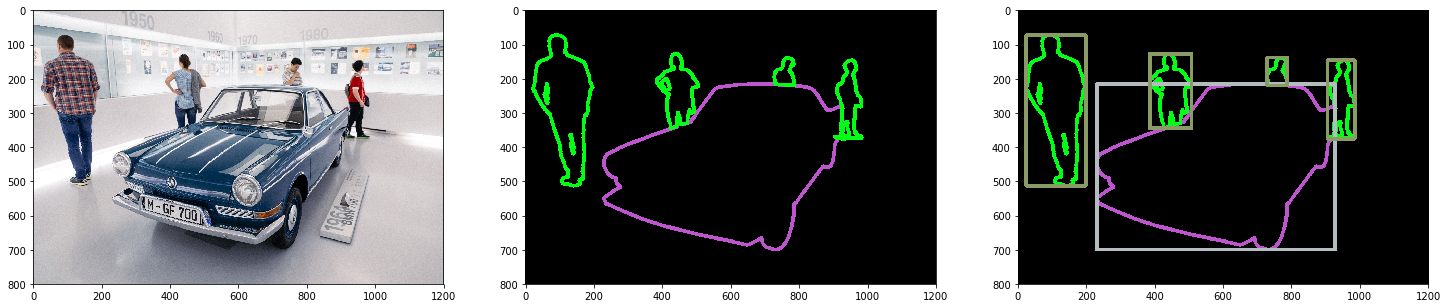

In [20]:
# Set up the new object classes for the bounding boxes.
# Rember, the object class determines the appropriate type for the labels,
# so we cannot reuse existing classes - trying to create a label with
# a Rectangle geometry when the object class asks for a Polygon would
# throw an error.
bbox_classes = [sly.ObjClass(name=source_class.name + '_bbox',
                             geometry_type=sly.Rectangle)
                for source_class in project.meta.obj_classes]

# Add the bounding boxes classes to the project meta.
# The result is the meta 
meta_with_bboxes = project.meta.add_obj_classes(bbox_classes)

# Load the data.
item_paths = project.datasets.get('dataset_01').get_item_paths('car-people-indoors')
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
img = sly.image.read(item_paths.img_path)

# Build bounding box labels for every existing label in the annotation.
bbox_labels = [
    sly.Label(geometry=label.geometry.to_bbox(),
              obj_class=meta_with_bboxes.obj_classes.get(label.obj_class.name + '_bbox'))
    for label in ann.labels]

# Add the bounding boxes to the annotation.
# Source annotation is unchanged, the returned result contains
# the additional bounding boxes along with the original labels.
ann_with_bboxes = ann.add_labels(bbox_labels)

# Draw and display the label contours, both for the original
# annotation and for the new one with the bounding boxes.
ann_render = np.zeros(ann_with_bboxes.img_size + (3,), dtype=np.uint8)
ann_with_bboxes_render = np.zeros(ann_with_bboxes.img_size + (3,), dtype=np.uint8)
ann.draw_contour(ann_render, thickness=10)
ann_with_bboxes.draw_contour(ann_with_bboxes_render, thickness=10)
display_images([img, ann_render, ann_with_bboxes_render], (25, 25))

### Label transform functions
Building up the set of updated labels externally works, but may be a bit cumbersome. An alternative is to use *transformation functions* that take a `Label` as an argument and return a list (possibly) empty of `Label` objects.

Here is an example of how we can achieve the same goal as above, adding bounding box labels, with a transformation function.

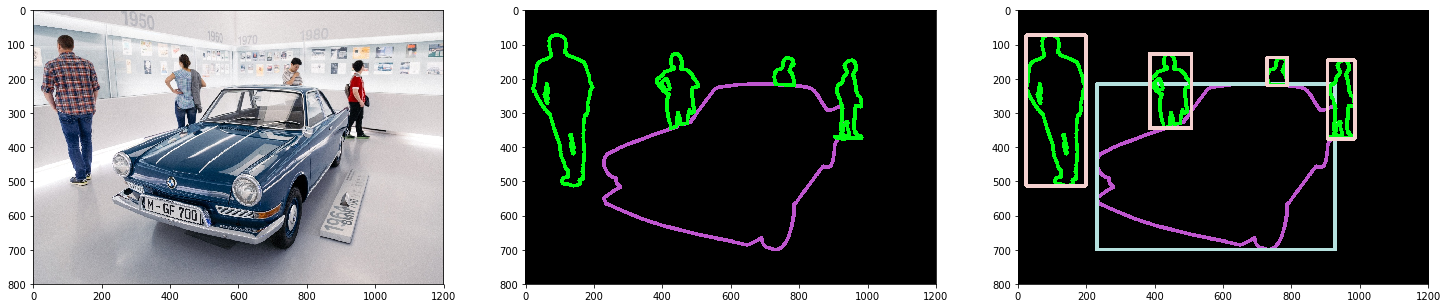

In [21]:
# --- Make bounding box classes, update meta, load data same as above --
bbox_classes = sly.ObjClassCollection(
    sly.ObjClass(name=source_class.name + '_bbox', geometry_type=sly.Rectangle)
    for source_class in project.meta.obj_classes)

meta_with_bboxes = project.meta.add_obj_classes(bbox_classes)

item_paths = project.datasets.get('dataset_01').get_item_paths('car-people-indoors')
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)
img = sly.image.read(item_paths.img_path)
# --- End of common setup functionality ---

# Define the transform function to add a bounding box label.
def add_bbox_fn(label, obj_classes):
    return [label,        # Keep the original label too
            sly.Label(    # Add the bounding box label
                geometry=label.geometry.to_bbox(),
                obj_class=obj_classes.get(label.obj_class.name + '_bbox'))]

# Apply the transformation. Use a lambda to forward any required state
# (in our cases the available object classes).
ann_with_bboxes = ann.transform_labels(
    lambda label : add_bbox_fn(label, meta_with_bboxes.obj_classes))

# Draw and display results.
ann_render = np.zeros(ann_with_bboxes.img_size + (3,), dtype=np.uint8)
ann_with_bboxes_render = np.zeros(ann_with_bboxes.img_size + (3,), dtype=np.uint8)
ann.draw_contour(ann_render, thickness=10)
ann_with_bboxes.draw_contour(ann_with_bboxes_render, thickness=10)
display_images([img, ann_render, ann_with_bboxes_render], (25, 25))

Transformation functions are more convenient especially when we want to apply a sequence of transformations. Say, we want to first filter the labels by area, and then add bounding boxes. With appropriate transformation functions defined (and possibly factored out to a library for reuse), the required call would be simply something like
```
ann.transform_labels(area_filter_fn).transform_labels(add_bbox_fn)
```
(with appropriate lambdas added to pass state to transformations).

## Working with tags

In addition to geometric labels, there are many possible attributes that do not have a geometric component to them. For example:
* Train-test splits of the images within the project.
* Classification labels for the whole images.
* Confidence scores for neural network predictions.

In the Supervisely system, all such data is handled using *tags*. The tags can be attached both to whole images and to individual geometric labels. The only limitation is that the image-level and label-level tags must have different names.

Similarly to the `ObjClass` objects, which store the metadata for the geometric labels, `TagMeta` objects store the metadata for the tags. Tag metadata includes tag name, value type, and possible values for tags with enum values. When creating a new tag, the value is automatically cross-checked against the metadata to make sure the value is valid.

Let us go over quick examples for all the tag types supported in the system.

### No-value tags
No-value tags are the simplest: they have no explicit value, and can be either present or absent from an image or a label. A typical use of no-value tags is to mark a train - validation split for training a neural net. Here is how one can mark this split using no-value tags:

In [22]:
# Make and open a cloned project where we will modify tags.
CLONED_PROJECT_NAME = 'cloned_project'
sly.io.fs.remove_dir('./' + CLONED_PROJECT_NAME)
project.copy_data(dst_directory='.', dst_name=CLONED_PROJECT_NAME)
cloned_project = sly.Project('./' + CLONED_PROJECT_NAME, sly.OpenMode.READ)

# Create TagMeta objects for the train and val tags.
# Set the tags to not have any values.
train_tag_meta = sly.TagMeta(name='train', value_type=sly.TagValueType.NONE)
val_tag_meta = sly.TagMeta(name='val', value_type=sly.TagValueType.NONE)

# Add the new TagMeta objects to the set of whole-image tags project.
meta_with_new_tags = cloned_project.meta.add_img_tag_metas([train_tag_meta, val_tag_meta])
# Save the new project meta to disk.
cloned_project.set_meta(meta_with_new_tags)

# Iterate over all the images in the project.
for dataset in cloned_project:
    for i, item_name in enumerate(dataset):
        ann = sly.Annotation.load_json_file(
            dataset.get_ann_path(item_name), cloned_project.meta)
        # Tag even-numbered images for training, odd-numbered for validation.
        if i % 2 == 0:
            # Don't forget to store the resulting Annotation objects as the
            # original annotations do not change.
            ann_added_tag = ann.add_tag(sly.Tag(train_tag_meta))
        else:
            ann_added_tag = ann.add_tag(sly.Tag(val_tag_meta))
        # Write out the updated annotation to disk.
        dataset.set_ann(item_name, ann_added_tag)

# Let us pick one image and see which side of the train/val split it has been assigned to.
# Load the data.
ann_path = cloned_project.datasets.get('dataset_01').get_ann_path('bicycle-car')
ann = sly.Annotation.load_json_file(ann_path, cloned_project.meta)

# Look up the tag names and print the results.
print('"train" tag in annotation: ' + str(ann.img_tags.has_key(train_tag_meta.name)))
print('"val" tag in annotation: ' + str(ann.img_tags.has_key(val_tag_meta.name)))
print()

# Finally try out the tag value validation. Our new tags have no values, so attempts to
# create tags with values should fail.
try:
    print('Trying to specify string value for a train tag...')
    tag = sly.Tag(meta=train_tag_meta, value='some_value')
except ValueError as e:
    print('Exception occured: ' + str(e))

"train" tag in annotation: True
"val" tag in annotation: False

Trying to specify string value for a train tag...
Exception occured: Tag train can not have value some_value


### Tags with values
Often we need to have more fine-grained information associated with a tag than just presence or absence. Supervisely supports attaching a value to a tag. There are 3 possible value types:
* `ANY_NUMBER` for numeric values. For example, an object detection neural net can use numeric tags to store detection confidence values.
* `ANY_STRING` for arbitrary string values. For example, for when labeling cars in the images we can use string valued tags to store the brand of a car.
* `ONEOF_STRING` for string values restricted to a given whitelist. For example, we can use such enum tags to store the car body types - there are relatively few body types, they are all known beforehand, and all other values would not make sense.

Here is an example of how we can use the different types of tags with values:

In [23]:
# Make and open a cloned project where we will modify tags.
CLONED_PROJECT_NAME = 'cloned_project'
sly.io.fs.remove_dir('./' + CLONED_PROJECT_NAME)
project.copy_data(dst_directory='.', dst_name=CLONED_PROJECT_NAME)
cloned_project = sly.Project('./' + CLONED_PROJECT_NAME, sly.OpenMode.READ)

# Create a TagMeta object for detection confidence.
# Set the value type to be numbers.
confidence_tag_meta = sly.TagMeta(name='confidence', value_type=sly.TagValueType.ANY_NUMBER)
# Create a TagMeta object for storing the car brand.
# Set the value type to be strings.
brand_tag_meta = sly.TagMeta(name='car_brand', value_type=sly.TagValueType.ANY_STRING)
# Create a TagMeta object for storing the car body type.
# Set the value type to be strings from a given whitelist.
body_tag_meta = sly.TagMeta(
    name='car_body',
    value_type=sly.TagValueType.ONEOF_STRING,
    possible_values=['sedan', 'hatchback', 'coupe'])

# Add the new tag meta objects to the set of object tags
# (i.e. attached to labels, not whole images).
meta_with_tags = cloned_project.meta.add_obj_tag_metas(
    [confidence_tag_meta, brand_tag_meta, body_tag_meta])

# Update meta on disk.
cloned_project.set_meta(meta_with_tags)

# Load the annotation for a given item.
ann_path = cloned_project.datasets.get('dataset_01').get_ann_path('bicycle-car')
ann = sly.Annotation.load_json_file(ann_path, cloned_project.meta)

# Look up the bike object class in the meta. We will only add a tag to the bike label.
bike_obj_class = cloned_project.meta.obj_classes.get('bike')
# Find the bike label by comparing the object class.
[bike_label] = [label for label in ann.labels if label.obj_class == bike_obj_class]
# Add a confidence tag. As usual, this produces a new label object.
bike_label_confidence = bike_label.add_tag(sly.Tag(meta=confidence_tag_meta, value=0.7))

print('Original bike tags: ')
print(bike_label.tags)
print('bike tags after adding confidence: ')
print(bike_label_confidence.tags)
print()


car_obj_class = cloned_project.meta.obj_classes.get('car')
[car_label] = [label for label in ann.labels if label.obj_class == car_obj_class]
car_label_with_tags = car_label.add_tags([
    sly.Tag(meta=brand_tag_meta, value='alfa romeo'),
    sly.Tag(meta=body_tag_meta, value='coupe')])


print('Original car tags: ')
print(car_label.tags)
print('car tags after adding more tags: ')
print(car_label_with_tags.tags)
print()

# Replace the label in the annotation with our modified version.
ann_with_tags = ann.delete_label(bike_label).delete_label(car_label).add_labels(
    [bike_label_confidence, car_label_with_tags])

Original bike tags: 
Tags:
+------+------------+-------+
| Name | Value type | Value |
+------+------------+-------+
+------+------------+-------+
bike tags after adding confidence: 
Tags:
+------------+------------+-------+
|    Name    | Value type | Value |
+------------+------------+-------+
| confidence | any_number |  0.7  |
+------------+------------+-------+

Original car tags: 
Tags:
+-------------+--------------+---------+
|     Name    |  Value type  |  Value  |
+-------------+--------------+---------+
| vehicle_age | oneof_string | vintage |
|  car_color  |  any_string  |   red   |
+-------------+--------------+---------+
car tags after adding more tags: 
Tags:
+-------------+--------------+------------+
|     Name    |  Value type  |   Value    |
+-------------+--------------+------------+
| vehicle_age | oneof_string |  vintage   |
|  car_color  |  any_string  |    red     |
|  car_brand  |  any_string  | alfa romeo |
|   car_body  | oneof_string |   coupe    |
+---------